In [1]:
import sys
from pathlib import Path
import IMP
import IMP.atom
import IMP.core
import IMP.algebra

sys.path.append(str(Path(Path.home(), "Documents/xray/src")))
import align_imp
import miller_ops
import cctbx_score
import update_weights_optimizer_state
from derivatives import get_df_mag_ratio



In [2]:
m = IMP.Model()
pdb_file = Path("../data/min.pdb")

h = IMP.atom.read_pdb(str(pdb_file), m, IMP.atom.AllPDBSelector())

params_file = Path("/Users/matthew/opt/anaconda3/envs/imp_221_cctbx/share/IMP/atom/par.lib")
topology_file = Path("/Users/matthew/opt/anaconda3/envs/imp_221_cctbx/share/IMP/atom/top.lib")

# ff = IMP.atom.CHARMMParameters(str(topology_file), str(params_file), True)
# topology = ff.create_topology(h)

ff = IMP.atom.get_all_atom_CHARMM_parameters()
topology = ff.create_topology(h)

topology.apply_default_patches()
topology.add_atom_types(h)

begin read_pdb:
  WARNING  Could not determine CHARMM atom type for atom "HE2" in residue #41 "HIS"
  WARNING  Could not determine CHARMM atom type for atom "H1" in residue #1 "SER"
end read_pdb
WARNING  Could not determine CHARMM atom type for atom "H1" in residue #1 "SER"
WARNING  Could not determine CHARMM atom type for atom "HE2" in residue #41 "HIS"


In [3]:

rs = list()

# Configure the IMP model based on the CHARMM parameterization.
# ff = IMP.atom.get_heavy_atom_CHARMM_parameters()
# pids = IMP.atom.Selection(h).get_selected_particle_indexes()
# print(len(pids))

ff = IMP.atom.get_all_atom_CHARMM_parameters()
topology = ff.create_topology(h)

## Why is this not fixing the NTER?
topology.apply_default_patches()
# topology.setup_hierarchy(h)
topology.add_atom_types(h)
# topology.add_missing_atoms(h)
IMP.atom.remove_charmm_untyped_atoms(h)
# topology.add_coordinates(h)

## setup charges first
charges = topology.add_charges(h)
bonds = topology.add_bonds(h)
angles = ff.create_angles(bonds)
dihedrals = ff.create_dihedrals(bonds)
impropers = topology.add_impropers(h)


# Add a restraint on the bond lengths.
cont = IMP.container.ListSingletonContainer(m, bonds, "bnd")
bss = IMP.atom.BondSingletonScore(IMP.core.Harmonic(0, 1))
r = IMP.container.SingletonsRestraint(bss, cont, "bnd")
rs.append(r)

# Add a restraint on the bond angles.
cont = IMP.container.ListSingletonContainer(m, angles, "ang")
bss = IMP.atom.AngleSingletonScore(IMP.core.Harmonic(0, 1))
r = IMP.container.SingletonsRestraint(bss, cont, "ang")
rs.append(r)

# Add a restraint on the dihedral angles.
cont = IMP.container.ListSingletonContainer(m, dihedrals, "dih")
bss = IMP.atom.DihedralSingletonScore()
r = IMP.container.SingletonsRestraint(bss, cont, "dih")
rs.append(r)

# Add a restraint on the improper dihedrals (out of plane bending).
cont = IMP.container.ListSingletonContainer(m, impropers, "imp")
bss = IMP.atom.ImproperSingletonScore(IMP.core.Harmonic(0, 1))
rs.append(IMP.container.SingletonsRestraint(bss, cont, "imp"))

slack = 0

# Add a restraint on the non-bonded atoms (Lennard-Jones potential).
ff.add_radii(h)
ff.add_well_depths(h)
atoms = IMP.atom.get_by_type(h, IMP.atom.ATOM_TYPE)
cont = IMP.container.ListSingletonContainer(m, atoms)
nbl = IMP.container.ClosePairContainer(cont, 3, slack)
pair_filter = IMP.atom.StereochemistryPairFilter()
pair_filter.set_bonds(bonds)
pair_filter.set_angles(angles)
pair_filter.set_dihedrals(dihedrals)
nbl.add_pair_filter(pair_filter)
sf = IMP.atom.ForceSwitch(6.0, 7.0)
ljps = IMP.atom.LennardJonesPairScore(sf)
rs.append(IMP.container.PairsRestraint(ljps, nbl, "nbd"))

sf = IMP.atom.ForceSwitch(6.0, 7.0)
cps = IMP.atom.CoulombPairScore(sf)
r_cps = IMP.container.PairsRestraint(cps, nbl, "eps")
rs.append(r_cps)



WARNING  Could not determine CHARMM atom type for atom "H1" in residue #1 "SER"
WARNING  Could not determine CHARMM atom type for atom "HE2" in residue #41 "HIS"


In [4]:
len(IMP.atom.Selection(h).get_selected_particles())

4676

In [5]:
pid = IMP.atom.Selection(h).get_selected_particle_indexes()[0]

for r in rs:
    print(r.get_name(), r.evaluate(True))
    print(IMP.core.XYZ(m, pid).get_derivatives())

print(IMP.core.XYZ(m, pid).get_derivatives())

bnd 2724.6113690630013
(9.98588, 32.4927, 0.0936071)
ang 5695.057894411382
(-30.5089, -6.64435, 9.90928)
dih 3045.728167265135
(-0.227656, 0.291682, -0.132957)
imp 821.9909569939557
(0.339304, -0.936844, 0.353992)
nbd -137.48119565089058
(-0.0482962, -0.114117, -0.136245)
eps -36558.01656073348
(-6.26, -13.1761, -2.72634)
(-6.26, -13.1761, -2.72634)


In [6]:
len(nbl.get_indexes())

158002

In [7]:
index = nbl.get_indexes()[0]
cps.evaluate_index(m, index, None)


-11.801929102029675

In [8]:
scores = list()
for index in nbl.get_indexes():
    at_1 = IMP.atom.Atom(m, index[0])
    at_2 = IMP.atom.Atom(m, index[1])
    scores.append(cps.evaluate_index(m, index, None))
    # print(at_1.get_name(), at_2.get_name(), cps.evaluate_index(m, index, None))

In [9]:
sum(scores)

-36558.016560733355

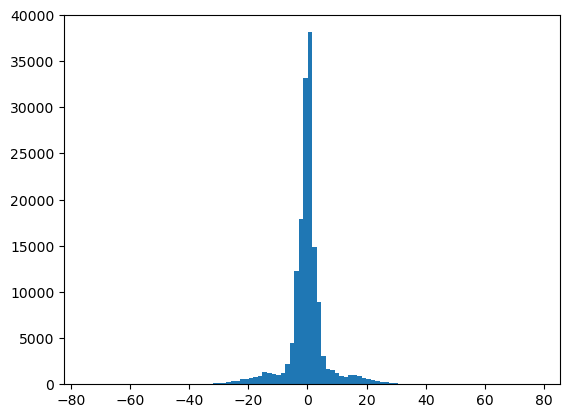

In [10]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=100)
plt.show()

In [11]:
pids = IMP.atom.Selection(h).get_selected_particles()
ps = [m.get_particle(pid) for pid in pids]
for pid in pids:
    IMP.core.XYZ(m, pid).set_coordinates_are_optimized(True)
    IMP.atom.LinearVelocity.setup_particle(m, pid, IMP.algebra.Vector3D(0, 0, 0))

In [12]:
sf = IMP.core.RestraintsScoringFunction(rs)

sf.evaluate(True)

-24408.109368650898

In [13]:
pid = IMP.atom.Selection(h).get_selected_particle_indexes()[0]
IMP.core.XYZ(m, pid).get_derivatives()

(-26.7196, 11.913, 7.36134)

In [14]:
# vel_therm = IMP.atom.BerendsenThermostatOptimizerState(ps, 300, 10)

md = IMP.atom.MolecularDynamics(m)

md.set_scoring_function(sf)
md.set_has_required_score_states(True)

md.setup(ps)
md.set_temperature(300)
md.set_maximum_time_step(1.0)
md.assign_velocities(300)

# md.add_optimizer_state(vel_therm)

md.simulate(100)


-26821.514134977795

In [16]:
nbl.get_number_of_full_rebuilds()

106

In [29]:
len(rs[5].get_inputs())

4677

In [15]:
IMP.atom.write_pdb(h, "out.pdb")

In [19]:
md.get_kinetic_temperature(md.get_kinetic_energy())

844.6338378894095

In [17]:
sf.evaluate(True)

-24360.991366962917

In [21]:
pid = IMP.atom.Selection(h).get_selected_particle_indexes()[0]

for r in rs:
    print(r.get_name(), r.evaluate(True))
    print(IMP.core.XYZ(m, pid).get_derivatives())

print(IMP.core.XYZ(m, pid).get_derivatives())

bnd 3833.6207037921504
(-62.0353, -15.5349, 46.314)
ang 7203.091052917933
(-28.6124, -16.552, -6.97472)
dih 3245.9049404781063
(0.337703, -0.829978, 0.321741)
imp 912.4762811023978
(-0.62114, 2.26847, 0.970481)
nbd -291.58412977297724
(-0.126579, -0.151027, -0.208164)
eps -39264.500215480526
(12.9226, -15.1253, 7.76144)
(12.9226, -15.1253, 7.76144)
